# Review Post Attributes Models

This notebook builds a range of machine learning models to predict a user's sentiment based upon various review post attributes.

* Section 1 - Import libraries and dataset
* Section 2 - Pre-processing and feature engineering
* Section 3 - Classifier Models and Summary



Datasets needed to run this notebook:

* explor1_processed.csv

Data saved to:

* sampled_data.csv


 Review Post Features used for modelling:
 
* User Past Contributions
* Town where the establishment is located
* Category - accommodation, food or attraction
* Date of review - when review is posted
* Location of user - overseas, local or rest of UK
* Outlet type - e.g. (hotel, B&B) or (restaurant,fast-food outlet)
* Cuisine type - e.g. British, Italian, Seafood etc


# Section 1: Import Libraries and Dataset

In [1]:
#!pip install -U imbalanced-learn

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import SelectKBest,chi2,RFECV,VarianceThreshold
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RepeatedStratifiedKFold,cross_val_score,learning_curve
from sklearn.dummy import DummyClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score, balanced_accuracy_score
from sklearn.metrics import auc,roc_auc_score,roc_curve,precision_recall_curve,plot_precision_recall_curve
from sklearn.metrics import precision_score,recall_score,f1_score,fbeta_score,f1_score

import warnings
warnings.filterwarnings("ignore")

In [3]:
# Read in dataset from MScExploratory Data Analysis Part One
df = pd.read_csv("explor1_processed.csv",index_col = 0)
#df.drop(columns = ["Title","Review","Name"],axis =1,inplace = True)

In [4]:
df.head(2)

,Name,Category,Town,Type,Contributions,Title,Review,Rating,Date,LocCode,Cuisine
0,Norfolk Arms,Accommodation,Arundel,Hotel,1278,Great value in the heart of arundel,Booked a room to stay the night in Arundel. Th...,4,4.0,2.0,0
1,Town House,Accommodation,Arundel,B&B/Inn,1163,"Excellent food,service and ambience!",We’ve eaten here with a group of friends who g...,5,4.0,2.0,0


In [5]:
df.shape

(10325, 11)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10325 entries, 0 to 10324
Data columns (total 11 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Name           10325 non-null  object 
 1   Category       10325 non-null  object 
 2   Town           10325 non-null  object 
 3   Type           10325 non-null  object 
 4   Contributions  10325 non-null  int64  
 5   Title          10325 non-null  object 
 6   Review         10325 non-null  object 
 7   Rating         10325 non-null  int64  
 8   Date           10325 non-null  float64
 9   LocCode        10325 non-null  float64
 10  Cuisine        10325 non-null  object 
dtypes: float64(2), int64(2), object(7)
memory usage: 968.0+ KB


# Section 2: Preprocessing and Feature Engineering

## Create binary score

In [7]:
# Create new column for Score and set binary values for ratings
df["Score"] = df["Rating"]
df = df[df["Rating"] != 3]
df.Score.replace([1,2], 1, inplace = True)
df.Score.replace([4,5], 0, inplace = True)
#df_changed.drop(columns = ["Rating"],axis = 1, inplace = True)

## Create sample

In [8]:
# Function to get balanced sample based on ratings for each dataframe
def sampling(df,sample_size):
    sampled_good = df[df["Score"] == 0].sample(sample_size)
    sampled_bad = df[df["Score"] == 1]
    new_df = sampled_good.append(sampled_bad)
    new_df = new_df.sample(frac=1).reset_index(drop=True)
    return new_df

In [9]:
df = sampling(df,df.Score.value_counts()[1])
df["Score"].value_counts()

0    1301
1    1301
Name: Score, dtype: int64

In [10]:
df.to_csv("sampled_data.csv")

## Combine types for simplification

In [11]:
# Get cuisine types
df["Cuisine"].value_counts()

British          1009
0                 859
Other             213
Seafood           136
Indian            129
Italian/Pizza     128
Chinese/Thai       65
American           61
International       2
Name: Cuisine, dtype: int64

In [12]:
# Strip whitespace from Type column
df.Type = df.Type.str.strip()

In [13]:
# Combine categories to simplify model
df["Cuisine"] = df["Cuisine"].replace(["Chinese/Thai","Indian"],"Asian/Oriental")
df["Cuisine"] = df["Cuisine"].replace(["Seafood","American","n/a"],["British","Other","Not Specified"])
df["Type"] = df["Type"].replace(["Steakhouse/Diner","Gastropub"],["Restaurant","Pub/Bar"])

In [14]:
df["Cuisine"].value_counts()

British           1145
0                  859
Other              274
Asian/Oriental     194
Italian/Pizza      128
International        2
Name: Cuisine, dtype: int64

In [15]:
df.head(2)

,Name,Category,Town,Type,Contributions,Title,Review,Rating,Date,LocCode,Cuisine,Score
0,Reema,Food,Littlehampton,Restaurant,1,Terrible,No Indian taste is all rubbish .customer servi...,1,1.0,0.0,Asian/Oriental,1
1,Zeera Lounge,Food,Bognor,Restaurant,22,Not impressed,Delivery was quick but the food was very disap...,2,3.0,1.0,Asian/Oriental,1


In [16]:
df.columns

Index(['Name', 'Category', 'Town', 'Type', 'Contributions', 'Title', 'Review',
       'Rating', 'Date', 'LocCode', 'Cuisine', 'Score'],
      dtype='object')

In [17]:
df = df.drop(columns = ["Name","Title","Review","Rating"],axis = 1)

## Create dummies

In [18]:
def change_funct(df):   
    
    # Set Date and LocCode to category
    df["Date"] = df["Date"].astype('category')
    df["LocCode"] = df["LocCode"].astype('category')
        
    # Rescale contributions column (standard scaler produces negative results so minmaxscaler is used)
    scaler = MinMaxScaler()
    df["Contributions"] = scaler.fit_transform(df[["Contributions"]])
    
    # Create dummies
    non_dummy_cols = df[["Contributions","Score"]]
    dummy_cols = list(set(df.columns) - set(non_dummy_cols))
    df = pd.get_dummies(df, columns=dummy_cols, drop_first = True)
    return df

In [19]:
df = change_funct(df)

In [20]:
heat = df.drop(columns = ["Score"],axis = 1)

## Look at relationships between the variables

[]

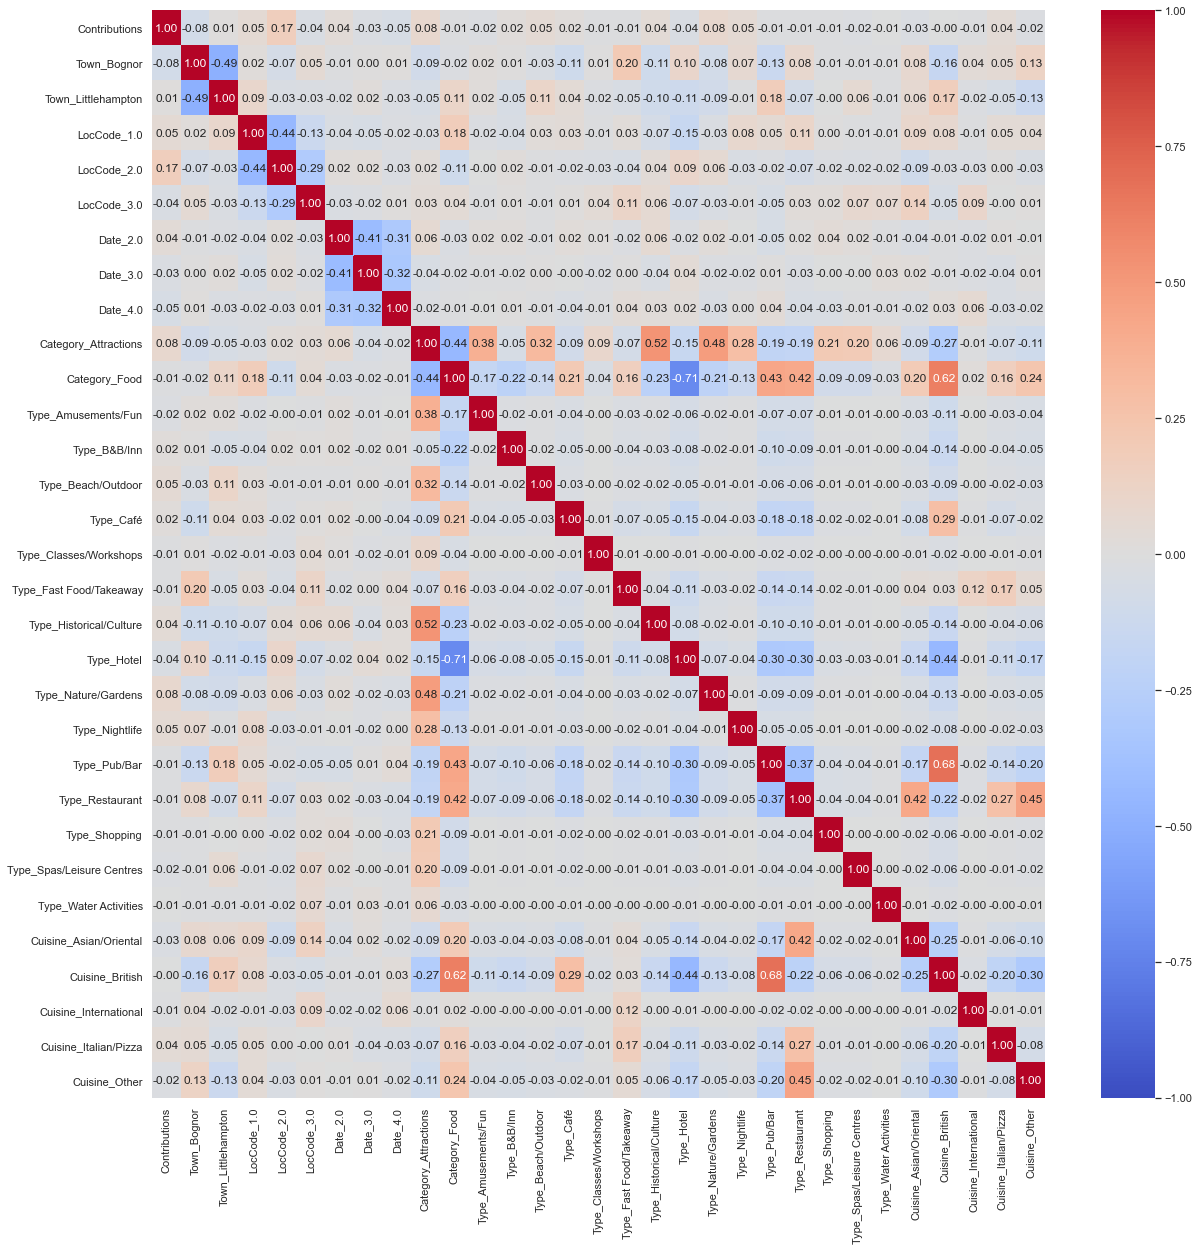

In [21]:
# Look at a heatmap to see where there might be relationships
plt.figure(figsize=(20,20))
sns.heatmap(heat.corr(), annot = True, vmin=-1, cmap='coolwarm',fmt=".2f")
plt.plot()

## Train, test, split

In [22]:
X = df.drop(columns = "Score",axis = 1)
y = df["Score"]

In [23]:
# Function to split each balanced dataframe into training, validation and test splits with a stratified rating value
def splitting(X,y):
    X_train, X_test, y_train, y_test = train_test_split(X,y, stratify = y,test_size=0.2, random_state=42)
    X_test, X_val, y_test, y_val = train_test_split(X_test, y_test,stratify = y_test, test_size=0.50, random_state=42)     
    return X_train,y_train,X_val,y_val,X_test,y_test

In [24]:
# Run function
X_train,y_train,X_val,y_val,X_test,y_test = splitting(X,y)
print(X_train.shape,y_train.shape,X_val.shape,y_val.shape,X_test.shape,y_test.shape)

(2081, 31) (2081,) (261, 31) (261,) (260, 31) (260,)


In [25]:
# Values of Scores - check balanced
y_train.value_counts()

1    1041
0    1040
Name: Score, dtype: int64

## Feature selection

Selecting the features most relevant to the score given as a proxy for sentiment

### a) Select K-best Features - Categorical Variables Only

,index,Scores
0,Category_Attractions,34.485539
1,Type_Fast Food/Takeaway,27.946212
2,Cuisine_Other,27.729567
3,Type_Historical/Culture,27.692047
4,Type_Nature/Gardens,26.097484
5,Type_Pub/Bar,17.697621
6,Cuisine_British,15.990634
7,Town_Littlehampton,15.650221
8,Type_Restaurant,14.550915
9,Type_Nightlife,9.953677


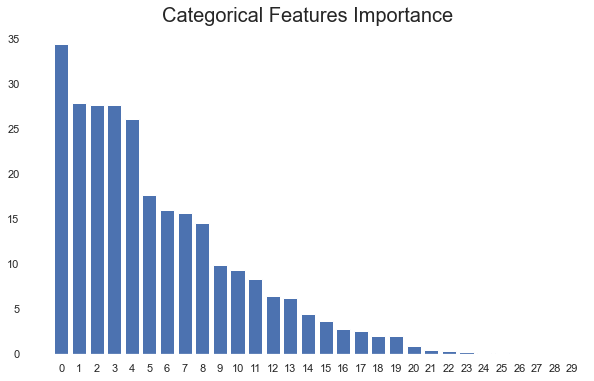

In [29]:
# Find the categorical features with the highest Chi squared value
X_train_cat = X_train.drop(columns = ["Contributions"])
chi2_selector = SelectKBest(chi2, k=10)
best = chi2_selector.fit(X_train_cat,y_train)
X_best = best.scores_
best_df = pd.DataFrame(X_best)
best_df.index = X_train_cat.columns
best_df_sorted = best_df.sort_values(by = 0,ascending = False)
best_df_sorted.columns = ["Scores"]
best_df_sorted = best_df_sorted.reset_index()
display(best_df_sorted.head(10))
#for i in range(len(best.scores_)):
    #print('Feature %d: %f' % (i, best.scores_[i]))

fig, ax = plt.subplots(figsize = (10,6))
ax.set_facecolor("White")
plt.bar([i for i in range(len(best_df))], best_df_sorted.Scores)
plt.title("Categorical Features Importance", size = 20)
plt.xticks(range(0,30),best_df_sorted.index)
plt.show()

### b) Recursive Feature Elimination

In [30]:
# Recursive Feature Elimination using cross validation to eliminate features that don't contribute to accuracy
def recurse(model,X,y):
    rfecv = RFECV(estimator = model, step = 1, scoring = "accuracy")
    rfecv.fit(X,y)
    rfecv.transform(X)
    return rfecv

In [31]:
# Set up recursive elimnatinon model
result = recurse(LogisticRegression(random_state = 0),X_train,y_train)

In [32]:
# Print number of important features
result.n_features_

25

In [33]:
# Grid Scores
result.grid_scores_

array([0.56559906, 0.57857291, 0.57520753, 0.57712599, 0.56703214,
       0.58962253, 0.60838176, 0.62084947, 0.62132909, 0.6227714 ,
       0.62854063, 0.62757909, 0.62278062, 0.62662678, 0.62373985,
       0.62325909, 0.62758601, 0.63094332, 0.63141602, 0.63237756,
       0.63669641, 0.63285256, 0.63333333, 0.64102564, 0.64150526,
       0.63717833, 0.63333333, 0.63429372, 0.63044526, 0.63381064,
       0.63381064])

In [34]:
# Rank the features
result.ranking_

array([1, 6, 1, 1, 1, 1, 2, 1, 5, 4, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3,
       1, 1, 1, 7, 1, 1, 1, 1, 1])

In [35]:
# Find those features the model suggests as significant
result.support_

array([ True, False,  True,  True,  True,  True, False,  True, False,
       False,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True, False,  True,  True,  True, False,  True,
        True,  True,  True,  True])

In [36]:
# List relevant features with names
df_2 = df.drop(["Score"],axis = 1)
features = pd.DataFrame(list(df_2.columns))
results = pd.DataFrame(result.support_)
results2 = pd.concat([features,results],axis = 1)
results2.columns = ["Feature","True/False"]
relevant = results2[results2["True/False"] == True]
relevant

,Feature,True/False
0,Contributions,True
2,Town_Littlehampton,True
3,LocCode_1.0,True
4,LocCode_2.0,True
5,LocCode_3.0,True
7,Date_3.0,True
10,Category_Food,True
11,Type_Amusements/Fun,True
12,Type_B&B/Inn,True
13,Type_Beach/Outdoor,True


In [37]:
# Choose just those columns for the model
X_train = X_train[relevant["Feature"]]
X_val = X_val[relevant["Feature"]]

# Section 3: Classifier Models

## a) Fitting and Training Models

There is an imbalanced number of examples of each class so the dataset is split into train and test sets to maintain the same proportions of examples for each class as found in the original dataset using stratifified K-fold.

In [38]:
# Function to train classifier models
def train_accuracy(model):
    rkf = RepeatedStratifiedKFold(n_splits = 10, n_repeats = 3)
    scores = cross_val_score(model, X_train, y_train, cv = rkf, scoring = 'accuracy',n_jobs =-1)
    return scores.mean()

Measure baseline performance, using a dummy classifier model that chooses the majority class each time. Different classifiers can be measured against this benchmark and should outperform it.

### Dummy Classifer and Baseline ML Models

In [39]:
# Set models with defaut parameters
dummy_model = DummyClassifier(strategy ='uniform')
nb = MultinomialNB()
lr = LogisticRegression()
rf = RandomForestClassifier()
svm = SVC(probability = True, kernel = 'rbf')

In [40]:
# Train models
dum_train = train_accuracy(dummy_model)
nb_train = train_accuracy(nb)
log_train = train_accuracy(lr)
rf_train = train_accuracy(rf)
svm_train = train_accuracy(svm)

In [41]:
train_summary = pd.DataFrame({"Dummy":[dum_train],"Naive Bayes":[nb_train],"LogReg":[log_train],"Random Forest": [rf_train],
                              "SVM":[svm_train]})
train_summary

,Dummy,Naive Bayes,LogReg,Random Forest,SVM
0,0.490466,0.615885,0.63768,0.587699,0.616517


The models outperformed the Dummy Classifier which is simply based on a uniform random selection

## b) Predicting With Each Model

Definitions:

A positive result (category of interest) is a BAD REVIEW which is this case is the minority class. 

A negative result is a GOOD REVIEW which is the majority class.

* TP = True Positive. Negative/bad reviews the model predicts as negative.
* TN = True Negative. Positive/good reviews the model predicts as positive.
* FP = False Positive. Positive/good reviews the model predicts as negative.
* FN = False Negative. Negative/bad reviews the model predicts as postitive.

In [42]:
# Create function to run diagnostic reports and graphs

def run_mod(model,X,y):
    
    # Fit model on training set and predict on test set
    model_name = str(model)
    model.fit(X,y)
    y_pred = model.predict(X_val)
        
    # Classification Report
    print(classification_report(y_val, y_pred))
    
    # Learning Curve    
    train_sizes, train_scores, val_scores = learning_curve(model,X,y, scoring = "accuracy",
                                                            n_jobs =-1,train_sizes = np.linspace(0.01,1.0,50))
    train_mean = np.mean(train_scores, axis = 1)
    train_std = np.std(train_scores, axis = 1)
    val_mean = np.mean(val_scores, axis = 1)
    val_std = np.mean(val_scores, axis = 1)
    
    plt.plot(train_sizes, train_mean, '--', color="#111111",  label="Training score")
    plt.plot(train_sizes, val_mean, color="#111111", label="Cross-validation score")
    plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color="#DDDDDD")
    plt.fill_between(train_sizes, val_mean - val_std, val_mean + val_std, color="#DDDDDD")

    plt.title("Learning Curve")
    plt.xlabel("Training Set Size"), plt.ylabel("Accuracy Score"), plt.legend(loc="best")
    plt.tight_layout()
    plt.show()
    
    # ROC Curve and AUC score
    target_probs = model.predict_proba(X_val)[:,1]
    false_positive_rate, true_positive_rate, threshold = roc_curve(y_val, target_probs)
    plt.title('Receiver Operating Characteristic')
    plt.plot(false_positive_rate, true_positive_rate)
    plt.plot([0, 1], ls="--")
    plt.plot([0, 0], [1, 0] , c=".7"), plt.plot([1, 1] , c=".7")
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()
    
    # Precision-Recall Curve 
    precision, recall, thresholds = precision_recall_curve(y_val,target_probs)
    no_skill = len(y_val[y_val==1]) / len(y_val)
    plt.plot(recall, precision, marker='.')
    plt.plot([0, 1], [no_skill,no_skill], linestyle='--', label='No Skill Model')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.show()
    
    # histogram of predicted probabilities of the positive
    plt.hist(target_probs)
    plt.xlim(0,1)
    plt.title('Histogram of predicted probabilities')
    plt.xlabel('Predicted probability of Bad Review')
    plt.ylabel('Frequency')
       
    # Metrics
    accuracy = accuracy_score(y_val, y_pred)
    balanced_accuracy = balanced_accuracy_score(y_val,y_pred)
    rocauc = roc_auc_score(y_val,target_probs)
    auc_score = auc(recall,precision)
    precision = precision_score(y_val, y_pred, average='binary')
    recall = recall_score(y_val, y_pred, average='binary')
    f1 = f1_score(y_val, y_pred, average='binary')
    f2_score = fbeta_score(y_val, y_pred, beta =2.0, labels=None, pos_label=1)
       
    
    run_mod.results = pd.DataFrame({"Accuracy":accuracy, "Balanced_acc":balanced_accuracy,
                                    "Precision":precision, "Recall":recall,
                                    "F1":f1,"F2":f2_score,"ROCAUC":rocauc,"PRAUC":auc_score}, index = [0]
                                  )
 
     
    # y_pred is an array of predictions
    best_thresh = None
    best_score = 0
    for thresh in np.arange(0.1, 0.501, 0.01):
        score = f1_score(y_val, y_pred>thresh)
        if score > best_score:
            best_thresh = thresh
            best_score = score
    print("Best F1 score:",best_score , "Best threshold value:",best_thresh)
                
    # Confusion Matrix
    fig, ax = plt.subplots()
    cf_matrix = confusion_matrix(y_val, y_pred)
    sns.heatmap(cf_matrix, annot = True, fmt = "d",)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title("Confusion Matrix", fontsize = 15)
    _ = ax.xaxis.set_ticklabels(['Good Reviews','Bad Reviews'],fontsize = 8)
    _ = ax.yaxis.set_ticklabels(['Good Reviews', 'Bad Reviews'], fontsize = 8)
    

### Naive Bayes Classifier

              precision    recall  f1-score   support

           0       0.68      0.40      0.50       131
           1       0.57      0.81      0.67       130

    accuracy                           0.60       261
   macro avg       0.62      0.60      0.58       261
weighted avg       0.62      0.60      0.58       261



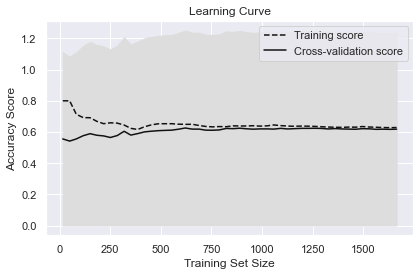

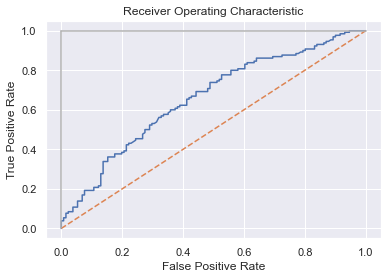

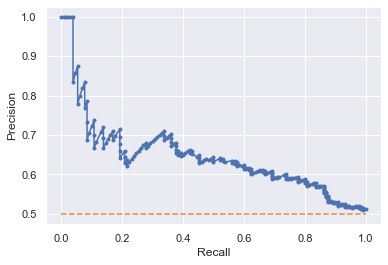

Best F1 score: 0.6687898089171974 Best threshold value: 0.1


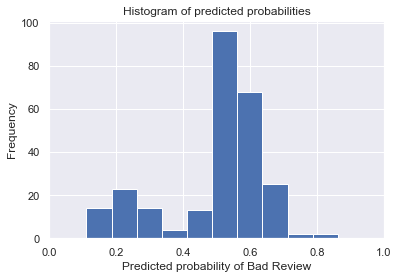

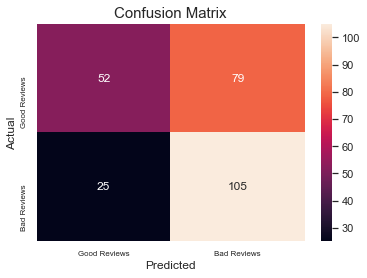

In [43]:
run_mod(nb,X_train,y_train)

In [44]:
nb_base = run_mod.results
nb_base

,Accuracy,Balanced_acc,Precision,Recall,F1,F2,ROCAUC,PRAUC
0,0.601533,0.602319,0.570652,0.807692,0.66879,0.745739,0.65825,0.645365


### Logistic Regression Classifier

              precision    recall  f1-score   support

           0       0.66      0.54      0.60       131
           1       0.61      0.72      0.66       130

    accuracy                           0.63       261
   macro avg       0.64      0.63      0.63       261
weighted avg       0.64      0.63      0.63       261



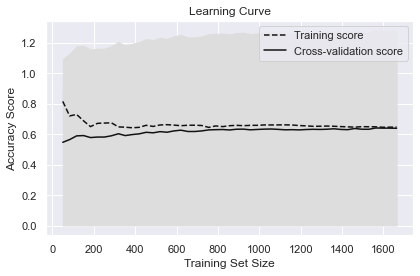

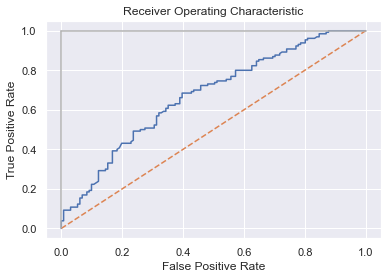

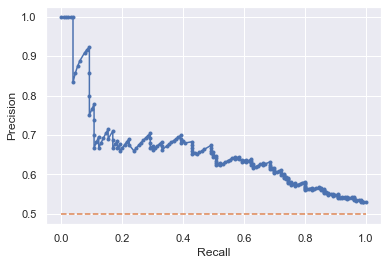

Best F1 score: 0.6619718309859155 Best threshold value: 0.1


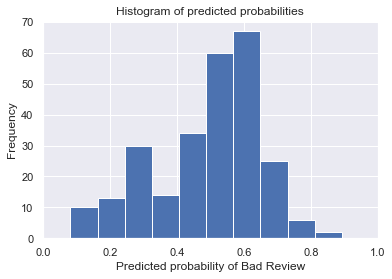

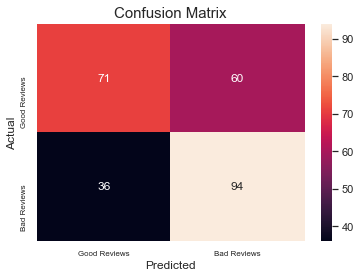

In [45]:
run_mod(lr,X_train,y_train)

In [46]:
lr_base = run_mod.results
lr_base

,Accuracy,Balanced_acc,Precision,Recall,F1,F2,ROCAUC,PRAUC
0,0.632184,0.632531,0.61039,0.723077,0.661972,0.697329,0.67158,0.657941


### Random Forest Classifier

              precision    recall  f1-score   support

           0       0.56      0.58      0.57       131
           1       0.56      0.54      0.55       130

    accuracy                           0.56       261
   macro avg       0.56      0.56      0.56       261
weighted avg       0.56      0.56      0.56       261



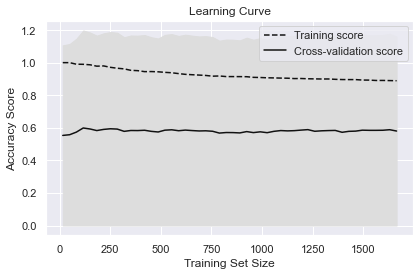

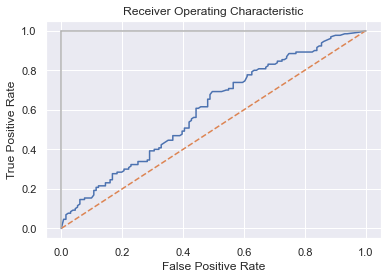

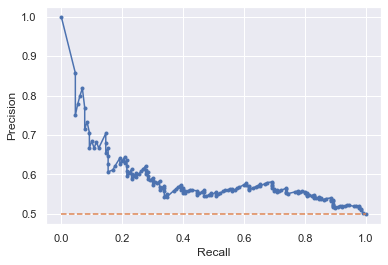

Best F1 score: 0.5490196078431373 Best threshold value: 0.1


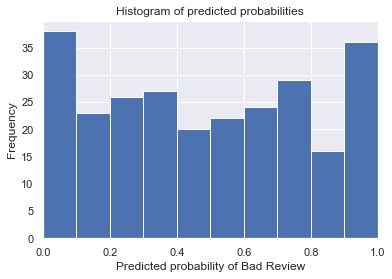

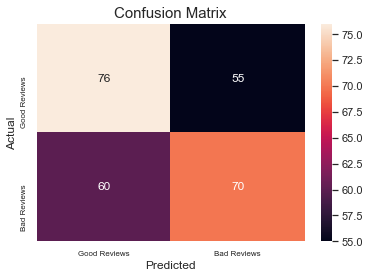

In [47]:
run_mod(rf,X_train,y_train)

In [48]:
rf_base = run_mod.results
rf_base

,Accuracy,Balanced_acc,Precision,Recall,F1,F2,ROCAUC,PRAUC
0,0.559387,0.559307,0.56,0.538462,0.54902,0.542636,0.599853,0.595125


### Support Vector Machine Classifier 

              precision    recall  f1-score   support

           0       0.61      0.56      0.58       131
           1       0.59      0.63      0.61       130

    accuracy                           0.60       261
   macro avg       0.60      0.60      0.60       261
weighted avg       0.60      0.60      0.60       261



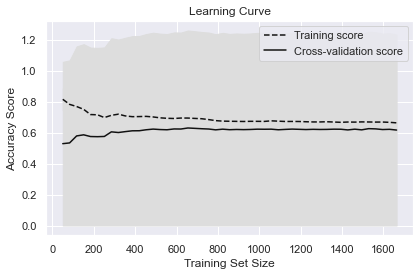

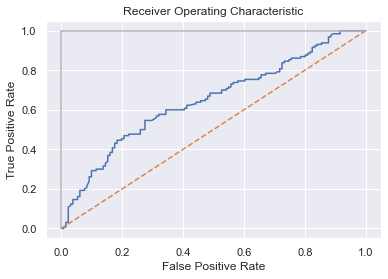

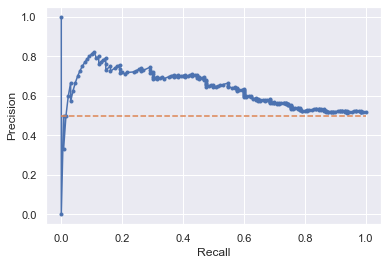

Best F1 score: 0.6096654275092938 Best threshold value: 0.1


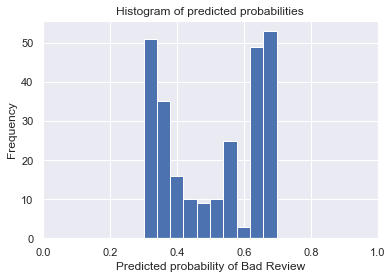

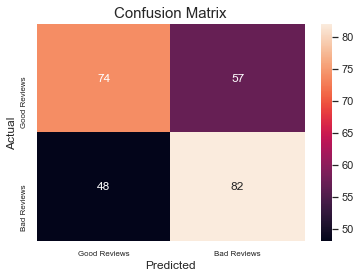

In [49]:
run_mod(svm,X_train,y_train)

In [50]:
svm_base = run_mod.results
svm_base

,Accuracy,Balanced_acc,Precision,Recall,F1,F2,ROCAUC,PRAUC
0,0.597701,0.597827,0.589928,0.630769,0.609665,0.622155,0.646947,0.633484


In [51]:
models = ["Multinomial NB","Logistic Regression","Random Forest","Support Vector"]

training_summary = pd.concat([nb_base,lr_base,rf_base,svm_base])
training_summary.set_index([models],inplace = True)
training_summary.drop(columns = ["Balanced_acc","F2","PRAUC"])

,Accuracy,Precision,Recall,F1,ROCAUC
Multinomial NB,0.601533,0.570652,0.807692,0.668790,0.658250
Logistic Regression,0.632184,0.610390,0.723077,0.661972,0.671580
Random Forest,0.559387,0.560000,0.538462,0.549020,0.599853
Support Vector,0.597701,0.589928,0.630769,0.609665,0.646947


Analysis:

* The results indicate that the post attributes models are fairly poor
* The best AUROC score is around 70%, so the model is not very good at separating the data into classes
* Recall is also fairly poor with only around 75 to 80% of reviews correctly identified as bad